In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [9]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

In [4]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

### Do updates

In [6]:
update_indexes()

Updated 2020-05-25, max actual date:     2020-05-22


In [8]:
update_stocks()

Updated 2020-05-25, max actual date:     2020-05-22


In [10]:
update_stocks_nc()

Updated 2020-05-25, max actual date:     2020-05-22


In [11]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 2438 and indexes: 23


## Single plot

### Plot code

In [15]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [12]:
[a for a in all_stocks if 'INTROL' in a]

['INTROL.mst']

In [13]:
papier = 'INTROL'

In [14]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/show/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


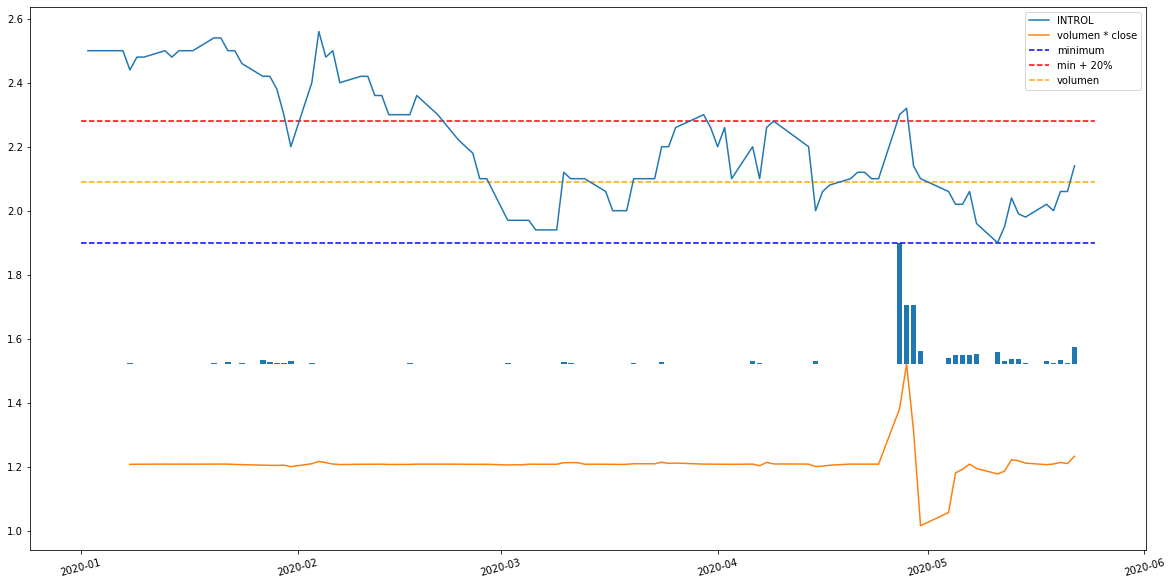

In [16]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [18]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: INTROL, currently at 2.14, with potential 19.63% to top
Max before crisis: 2.56
Crisis bottom: 1.94
Max after crisis drop: 2.32, at 2020-04-28 00:00:00
Stats after Max: [2.32 2.14 2.1  2.06 2.02 2.02 2.06 1.96 1.9  1.95 2.04 1.99 1.98 2.02
 2.   2.06 2.06 2.14]


## Skaner

In [17]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [18]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 2438/2438 [00:22<00:00, 109.79it/s]


In [19]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [20]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 25000)
                              ,:].sort_values('drop_current', ascending=True)

In [21]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

In [22]:
skaner_df_see.dropna().shape

(176, 15)

In [23]:
skaner_df_see.dropna().head(10)

,ticker,current,mean_VOL,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,ITMTRADE,0.280,2.835883e+04,1.270,2.200,2.600,0.218,1.090,2.200,-42.27,-15.38,400.00,28.44,685.71,-87.27
0,ELKOP,0.304,2.682140e+04,1.080,0.836,0.744,0.290,1.240,1.250,29.19,12.37,327.59,4.83,311.18,-75.68
0,MABION,25.900,3.535715e+04,51.100,80.000,73.500,17.960,31.000,103.600,-36.12,8.84,72.61,44.21,300.00,-75.00
0,BRASTER,0.334,4.393318e+05,0.370,1.040,1.730,0.200,0.405,1.162,-64.42,-39.88,102.50,67.00,247.90,-71.26
0,ELBUDOWA,2.850,1.165059e+05,7.680,6.260,10.100,1.200,5.300,9.240,22.68,-38.02,341.67,137.50,224.21,-69.16
0,CCC,43.700,5.350955e+05,96.500,132.500,153.900,24.980,51.820,133.000,-27.17,-13.91,107.45,74.94,204.35,-67.14
0,MOBIMEDIA,0.400,1.672299e+05,0.725,0.446,0.129,0.246,0.400,1.210,62.56,245.74,62.60,62.60,202.50,-66.94
0,ALIOR,13.435,7.947397e+05,27.680,38.020,51.750,11.750,16.920,38.240,-27.20,-26.53,44.00,14.34,184.63,-64.87
0,WORKSERV,0.440,3.933142e+05,0.502,0.860,2.210,0.342,0.480,1.144,-41.63,-61.09,40.35,28.65,160.00,-61.54
0,MILLENNIUM,2.506,1.467597e+06,6.065,5.650,9.535,2.298,3.880,6.395,7.35,-40.74,68.84,9.05,155.19,-60.81


## Model

In [24]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

#     df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
#     df.loc[df.loc[:, 'max_5d'].shift(-5) > df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 1
#     df.loc[df.loc[:, 'max_5d'].shift(-5) <= df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 0
    
    df.loc[:, 'max_1d'] = df.loc[:, 'HIGH'].rolling(1).max()
    df.loc[df.loc[:, 'max_1d'].shift(-1) > df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 1
    df.loc[df.loc[:, 'max_1d'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
#     for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
#         for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
#             df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
#             df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
#             df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
#             df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [25]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [26]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [27]:
full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 98%|█████████▊| 184/187 [03:26<00:03,  1.12s/it]


In [28]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

 98%|█████████▊| 183/186 [00:07<00:00, 24.22it/s]


In [29]:
df_papers = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_papers = pd.concat([df_papers , df])
    pbar.update(1)
pbar.close()

100%|██████████| 17/17 [00:10<00:00,  1.61it/s]


In [30]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

94

In [31]:
df_indexes = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes = pd.concat([df_indexes, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 23.33it/s]


In [32]:
df_indexes = df_indexes.reset_index().groupby('DTYYYYMMDD')[['OPEN', 'HIGH', 'CLOSE']].agg(['mean', 'max', 'std']).dropna(how = 'all',axis = 1)
df_indexes.columns = 'foreign_stocks_' + df_indexes.columns.get_level_values(1) + '_chng_' + df_indexes.columns.get_level_values(0)
df_indexes = df_indexes.dropna(how = 'all',axis = 1)

In [33]:
df_merged = df_papers.merge(df_indexes, left_index=True, right_index=True, how = 'left')

train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

In [34]:
valid = df_merged.loc[df_merged.index >= '2020-04-01'].copy()

df_merged = df_merged.loc[df_merged.index < '2020-04-01']

cut_date = '2019-11-01'
train_data = df_merged.loc[df_merged.index < cut_date,train_cols]
eval_data = df_merged.loc[df_merged.index >= cut_date,train_cols]
train_labels = df_merged.loc[df_merged.index < cut_date,'target'].values
eval_labels = df_merged.loc[df_merged.index >= cut_date,'target'].values

In [35]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.02,
                               #bagging_temperature=3,
                               #random_strength = 3,
                               use_best_model=True,
                               min_data_in_leaf=200,
                               #sampling_frequency=1,
                               #subsample = 0.8,
                           depth=5,
                               has_time=True,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='CPU')
    return model

In [36]:
model = get_model()

In [37]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          #eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=100, use_best_model=True)

0:	test: 0.7540196	best: 0.7540196 (0)	total: 330ms	remaining: 55m 2s
1:	test: 0.7594382	best: 0.7594382 (1)	total: 609ms	remaining: 50m 44s
2:	test: 0.7620758	best: 0.7620758 (2)	total: 869ms	remaining: 48m 16s
3:	test: 0.7638900	best: 0.7638900 (3)	total: 1.15s	remaining: 47m 42s
4:	test: 0.7647962	best: 0.7647962 (4)	total: 1.43s	remaining: 47m 31s
5:	test: 0.7671936	best: 0.7671936 (5)	total: 1.73s	remaining: 48m 5s
6:	test: 0.7683552	best: 0.7683552 (6)	total: 2.01s	remaining: 47m 50s
7:	test: 0.7689186	best: 0.7689186 (7)	total: 2.3s	remaining: 47m 58s
8:	test: 0.7697546	best: 0.7697546 (8)	total: 2.56s	remaining: 47m 27s
9:	test: 0.7698569	best: 0.7698569 (9)	total: 2.88s	remaining: 47m 53s
10:	test: 0.7708316	best: 0.7708316 (10)	total: 3.15s	remaining: 47m 44s
11:	test: 0.7711062	best: 0.7711062 (11)	total: 3.44s	remaining: 47m 46s
12:	test: 0.7708497	best: 0.7711062 (11)	total: 3.73s	remaining: 47m 43s
13:	test: 0.7715209	best: 0.7715209 (13)	total: 4s	remaining: 47m 33s
14:	

113:	test: 0.7779903	best: 0.7779903 (113)	total: 32.7s	remaining: 47m 15s
114:	test: 0.7779610	best: 0.7779903 (113)	total: 33s	remaining: 47m 17s
115:	test: 0.7779888	best: 0.7779903 (113)	total: 33.3s	remaining: 47m 15s
116:	test: 0.7780166	best: 0.7780166 (116)	total: 33.6s	remaining: 47m 15s
117:	test: 0.7780317	best: 0.7780317 (117)	total: 33.9s	remaining: 47m 16s
118:	test: 0.7780213	best: 0.7780317 (117)	total: 34.2s	remaining: 47m 18s
119:	test: 0.7780410	best: 0.7780410 (119)	total: 34.5s	remaining: 47m 17s
120:	test: 0.7780710	best: 0.7780710 (120)	total: 34.7s	remaining: 47m 15s
121:	test: 0.7780622	best: 0.7780710 (120)	total: 35s	remaining: 47m 14s
122:	test: 0.7781022	best: 0.7781022 (122)	total: 35.3s	remaining: 47m 15s
123:	test: 0.7781216	best: 0.7781216 (123)	total: 35.6s	remaining: 47m 14s
124:	test: 0.7781257	best: 0.7781257 (124)	total: 35.9s	remaining: 47m 15s
125:	test: 0.7781323	best: 0.7781323 (125)	total: 36.2s	remaining: 47m 13s
126:	test: 0.7781419	best: 0.

224:	test: 0.7793128	best: 0.7793128 (224)	total: 1m 5s	remaining: 47m 22s
225:	test: 0.7793108	best: 0.7793128 (224)	total: 1m 5s	remaining: 47m 22s
226:	test: 0.7793374	best: 0.7793374 (226)	total: 1m 6s	remaining: 47m 21s
227:	test: 0.7793300	best: 0.7793374 (226)	total: 1m 6s	remaining: 47m 20s
228:	test: 0.7793496	best: 0.7793496 (228)	total: 1m 6s	remaining: 47m 20s
229:	test: 0.7793426	best: 0.7793496 (228)	total: 1m 6s	remaining: 47m 20s
230:	test: 0.7793602	best: 0.7793602 (230)	total: 1m 7s	remaining: 47m 21s
231:	test: 0.7793651	best: 0.7793651 (231)	total: 1m 7s	remaining: 47m 20s
232:	test: 0.7793884	best: 0.7793884 (232)	total: 1m 7s	remaining: 47m 18s
233:	test: 0.7793977	best: 0.7793977 (233)	total: 1m 8s	remaining: 47m 20s
234:	test: 0.7794238	best: 0.7794238 (234)	total: 1m 8s	remaining: 47m 18s
235:	test: 0.7794264	best: 0.7794264 (235)	total: 1m 8s	remaining: 47m 18s
236:	test: 0.7794090	best: 0.7794264 (235)	total: 1m 8s	remaining: 47m 18s
237:	test: 0.7794264	best

333:	test: 0.7800381	best: 0.7800496 (329)	total: 1m 36s	remaining: 46m 22s
334:	test: 0.7800168	best: 0.7800496 (329)	total: 1m 36s	remaining: 46m 21s
335:	test: 0.7800194	best: 0.7800496 (329)	total: 1m 36s	remaining: 46m 21s
336:	test: 0.7800215	best: 0.7800496 (329)	total: 1m 37s	remaining: 46m 21s
337:	test: 0.7800423	best: 0.7800496 (329)	total: 1m 37s	remaining: 46m 20s
338:	test: 0.7800473	best: 0.7800496 (329)	total: 1m 37s	remaining: 46m 20s
339:	test: 0.7800490	best: 0.7800496 (329)	total: 1m 37s	remaining: 46m 19s
340:	test: 0.7800510	best: 0.7800510 (340)	total: 1m 38s	remaining: 46m 17s
341:	test: 0.7800393	best: 0.7800510 (340)	total: 1m 38s	remaining: 46m 16s
342:	test: 0.7800520	best: 0.7800520 (342)	total: 1m 38s	remaining: 46m 15s
343:	test: 0.7800482	best: 0.7800520 (342)	total: 1m 38s	remaining: 46m 16s
344:	test: 0.7800434	best: 0.7800520 (342)	total: 1m 39s	remaining: 46m 15s
345:	test: 0.7800492	best: 0.7800520 (342)	total: 1m 39s	remaining: 46m 15s
346:	test: 0

442:	test: 0.7804631	best: 0.7804718 (441)	total: 2m 8s	remaining: 46m 16s
443:	test: 0.7804604	best: 0.7804718 (441)	total: 2m 8s	remaining: 46m 15s
444:	test: 0.7804789	best: 0.7804789 (444)	total: 2m 9s	remaining: 46m 14s
445:	test: 0.7804742	best: 0.7804789 (444)	total: 2m 9s	remaining: 46m 13s
446:	test: 0.7804809	best: 0.7804809 (446)	total: 2m 9s	remaining: 46m 12s
447:	test: 0.7804861	best: 0.7804861 (447)	total: 2m 10s	remaining: 46m 11s
448:	test: 0.7804938	best: 0.7804938 (448)	total: 2m 10s	remaining: 46m 11s
449:	test: 0.7804977	best: 0.7804977 (449)	total: 2m 10s	remaining: 46m 11s
450:	test: 0.7804988	best: 0.7804988 (450)	total: 2m 10s	remaining: 46m 11s
451:	test: 0.7804908	best: 0.7804988 (450)	total: 2m 11s	remaining: 46m 12s
452:	test: 0.7804993	best: 0.7804993 (452)	total: 2m 11s	remaining: 46m 12s
453:	test: 0.7804912	best: 0.7804993 (452)	total: 2m 11s	remaining: 46m 12s
454:	test: 0.7805022	best: 0.7805022 (454)	total: 2m 12s	remaining: 46m 13s
455:	test: 0.7805

551:	test: 0.7807528	best: 0.7807597 (549)	total: 2m 40s	remaining: 45m 47s
552:	test: 0.7807545	best: 0.7807597 (549)	total: 2m 40s	remaining: 45m 47s
553:	test: 0.7807507	best: 0.7807597 (549)	total: 2m 41s	remaining: 45m 48s
554:	test: 0.7807556	best: 0.7807597 (549)	total: 2m 41s	remaining: 45m 48s
555:	test: 0.7807566	best: 0.7807597 (549)	total: 2m 41s	remaining: 45m 48s
556:	test: 0.7807734	best: 0.7807734 (556)	total: 2m 42s	remaining: 45m 48s
557:	test: 0.7807791	best: 0.7807791 (557)	total: 2m 42s	remaining: 45m 48s
558:	test: 0.7807875	best: 0.7807875 (558)	total: 2m 42s	remaining: 45m 49s
559:	test: 0.7807814	best: 0.7807875 (558)	total: 2m 43s	remaining: 45m 48s
560:	test: 0.7807792	best: 0.7807875 (558)	total: 2m 43s	remaining: 45m 47s
561:	test: 0.7807951	best: 0.7807951 (561)	total: 2m 43s	remaining: 45m 47s
562:	test: 0.7807682	best: 0.7807951 (561)	total: 2m 43s	remaining: 45m 46s
563:	test: 0.7807816	best: 0.7807951 (561)	total: 2m 44s	remaining: 45m 46s
564:	test: 0

660:	test: 0.7810563	best: 0.7810770 (653)	total: 3m 12s	remaining: 45m 22s
661:	test: 0.7810506	best: 0.7810770 (653)	total: 3m 12s	remaining: 45m 21s
662:	test: 0.7810561	best: 0.7810770 (653)	total: 3m 13s	remaining: 45m 20s
663:	test: 0.7810560	best: 0.7810770 (653)	total: 3m 13s	remaining: 45m 20s
664:	test: 0.7810629	best: 0.7810770 (653)	total: 3m 13s	remaining: 45m 19s
665:	test: 0.7810600	best: 0.7810770 (653)	total: 3m 14s	remaining: 45m 19s
666:	test: 0.7810716	best: 0.7810770 (653)	total: 3m 14s	remaining: 45m 18s
667:	test: 0.7810628	best: 0.7810770 (653)	total: 3m 14s	remaining: 45m 17s
668:	test: 0.7810626	best: 0.7810770 (653)	total: 3m 14s	remaining: 45m 17s
669:	test: 0.7810599	best: 0.7810770 (653)	total: 3m 15s	remaining: 45m 16s
670:	test: 0.7810622	best: 0.7810770 (653)	total: 3m 15s	remaining: 45m 15s
671:	test: 0.7810629	best: 0.7810770 (653)	total: 3m 15s	remaining: 45m 15s
672:	test: 0.7810821	best: 0.7810821 (672)	total: 3m 15s	remaining: 45m 15s
673:	test: 0

769:	test: 0.7812461	best: 0.7812528 (768)	total: 3m 44s	remaining: 44m 54s
770:	test: 0.7812614	best: 0.7812614 (770)	total: 3m 45s	remaining: 44m 53s
771:	test: 0.7812527	best: 0.7812614 (770)	total: 3m 45s	remaining: 44m 54s
772:	test: 0.7812517	best: 0.7812614 (770)	total: 3m 45s	remaining: 44m 54s
773:	test: 0.7812367	best: 0.7812614 (770)	total: 3m 45s	remaining: 44m 53s
774:	test: 0.7812333	best: 0.7812614 (770)	total: 3m 46s	remaining: 44m 52s
775:	test: 0.7812308	best: 0.7812614 (770)	total: 3m 46s	remaining: 44m 51s
776:	test: 0.7812331	best: 0.7812614 (770)	total: 3m 46s	remaining: 44m 51s
777:	test: 0.7812445	best: 0.7812614 (770)	total: 3m 47s	remaining: 44m 51s
778:	test: 0.7812445	best: 0.7812614 (770)	total: 3m 47s	remaining: 44m 51s
779:	test: 0.7812500	best: 0.7812614 (770)	total: 3m 47s	remaining: 44m 52s
780:	test: 0.7812528	best: 0.7812614 (770)	total: 3m 48s	remaining: 44m 51s
781:	test: 0.7812616	best: 0.7812616 (781)	total: 3m 48s	remaining: 44m 51s
782:	test: 0

878:	test: 0.7813977	best: 0.7814085 (864)	total: 4m 17s	remaining: 44m 28s
879:	test: 0.7813984	best: 0.7814085 (864)	total: 4m 17s	remaining: 44m 27s
880:	test: 0.7813966	best: 0.7814085 (864)	total: 4m 17s	remaining: 44m 26s
881:	test: 0.7813945	best: 0.7814085 (864)	total: 4m 17s	remaining: 44m 26s
882:	test: 0.7813964	best: 0.7814085 (864)	total: 4m 18s	remaining: 44m 26s
883:	test: 0.7814022	best: 0.7814085 (864)	total: 4m 18s	remaining: 44m 26s
884:	test: 0.7813963	best: 0.7814085 (864)	total: 4m 18s	remaining: 44m 26s
885:	test: 0.7813954	best: 0.7814085 (864)	total: 4m 19s	remaining: 44m 26s
886:	test: 0.7813943	best: 0.7814085 (864)	total: 4m 19s	remaining: 44m 25s
887:	test: 0.7813865	best: 0.7814085 (864)	total: 4m 19s	remaining: 44m 24s
888:	test: 0.7813860	best: 0.7814085 (864)	total: 4m 20s	remaining: 44m 24s
889:	test: 0.7813912	best: 0.7814085 (864)	total: 4m 20s	remaining: 44m 25s
890:	test: 0.7813886	best: 0.7814085 (864)	total: 4m 20s	remaining: 44m 25s
891:	test: 0

987:	test: 0.7814373	best: 0.7814685 (929)	total: 4m 50s	remaining: 44m 6s
988:	test: 0.7814379	best: 0.7814685 (929)	total: 4m 50s	remaining: 44m 5s
989:	test: 0.7814273	best: 0.7814685 (929)	total: 4m 50s	remaining: 44m 4s
990:	test: 0.7814332	best: 0.7814685 (929)	total: 4m 50s	remaining: 44m 4s
991:	test: 0.7814312	best: 0.7814685 (929)	total: 4m 51s	remaining: 44m 4s
992:	test: 0.7814336	best: 0.7814685 (929)	total: 4m 51s	remaining: 44m 3s
993:	test: 0.7814335	best: 0.7814685 (929)	total: 4m 51s	remaining: 44m 3s
994:	test: 0.7814320	best: 0.7814685 (929)	total: 4m 51s	remaining: 44m 2s
995:	test: 0.7814298	best: 0.7814685 (929)	total: 4m 52s	remaining: 44m 1s
996:	test: 0.7814342	best: 0.7814685 (929)	total: 4m 52s	remaining: 44m 1s
997:	test: 0.7814300	best: 0.7814685 (929)	total: 4m 52s	remaining: 44m 1s
998:	test: 0.7814272	best: 0.7814685 (929)	total: 4m 53s	remaining: 44m
999:	test: 0.7814279	best: 0.7814685 (929)	total: 4m 53s	remaining: 44m
1000:	test: 0.7814304	best: 0.7

1094:	test: 0.7814122	best: 0.7814905 (1022)	total: 5m 21s	remaining: 43m 34s
1095:	test: 0.7814078	best: 0.7814905 (1022)	total: 5m 21s	remaining: 43m 34s
1096:	test: 0.7814095	best: 0.7814905 (1022)	total: 5m 22s	remaining: 43m 33s
1097:	test: 0.7814067	best: 0.7814905 (1022)	total: 5m 22s	remaining: 43m 32s
1098:	test: 0.7814414	best: 0.7814905 (1022)	total: 5m 22s	remaining: 43m 32s
1099:	test: 0.7814473	best: 0.7814905 (1022)	total: 5m 22s	remaining: 43m 31s
1100:	test: 0.7814436	best: 0.7814905 (1022)	total: 5m 23s	remaining: 43m 32s
1101:	test: 0.7814453	best: 0.7814905 (1022)	total: 5m 23s	remaining: 43m 31s
1102:	test: 0.7814356	best: 0.7814905 (1022)	total: 5m 23s	remaining: 43m 31s
1103:	test: 0.7814307	best: 0.7814905 (1022)	total: 5m 24s	remaining: 43m 30s
1104:	test: 0.7814341	best: 0.7814905 (1022)	total: 5m 24s	remaining: 43m 30s
1105:	test: 0.7814363	best: 0.7814905 (1022)	total: 5m 24s	remaining: 43m 29s
1106:	test: 0.7814319	best: 0.7814905 (1022)	total: 5m 24s	remai

In [38]:
model.get_feature_importance(prettified=True).head(50)

,Feature Id,Importances
0,roll120std_diff_LOW_HIGH,4.329572
1,roll120max_diff_LOW_HIGH,3.795704
2,diff_LOW_HIGH,2.785350
3,roll40std_diff_LOW_HIGH,2.620629
4,roll20max_diff_LOW_HIGH,2.504395
5,roll120m_diff_LOW_CLOSE,2.437267
6,roll40std_diff_LOW_CLOSE,2.228160
7,roll80max_diff_LOW_HIGH,2.194752
8,roll5m_diff_LOW_HIGH,2.187658
9,roll20std_diff_OPEN_CLOSE,1.831387


In [39]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

150

### Check performance

In [40]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [41]:
preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [42]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[11243,   741],
       [ 3038,  1219]])

In [43]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(11243, 741, 3038, 1219)

In [44]:
(tn + tp) / (tn + tp + fp + fn)

0.7673172834185087

In [45]:
tp / (tp + fp)

0.621938775510204

In [46]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.797737,0.202263
1.0,0.610587,0.389413


In [47]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

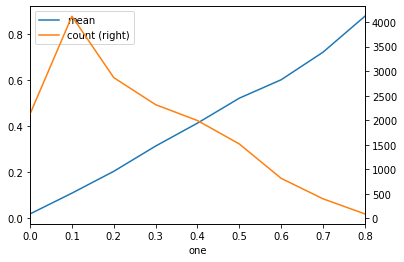

In [48]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [49]:
df_res_grouped

,mean,count
one,,
0.0,0.018318,2129
0.1,0.108495,4120
0.2,0.203278,2868
0.3,0.312905,2317
0.4,0.412444,1993
0.5,0.520792,1515
0.6,0.600737,814
0.7,0.720403,397
0.8,0.876404,89


#### Check valid

In [50]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [51]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [52]:
confusion_matrix(valid_labels[:-1].astype(int), preds)

array([[3464,  319],
       [1423,  439]])

In [53]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(3464, 319, 1423, 439)

In [54]:
(tn + tp) / (tn + tp + fp + fn)

0.69140832595217

In [55]:
tp / (tp + fp)

0.579155672823219

### Prediction

In [60]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [61]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [62]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()


 91%|█████████▏| 161/176 [03:16<00:15,  1.03s/it]


 98%|█████████▊| 172/176 [03:26<00:04,  1.20s/it]


In [63]:
qtransformed.qsize()

176

In [64]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)


100%|██████████| 176/176 [00:00<00:00, 689.99it/s]


In [65]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [66]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [67]:
prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")

'2020-05-22'

In [77]:
res.loc[res.DTYYYYMMDD == prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")]\
.sort_values('pred_prob', ascending=False).dropna(how='all', axis = 1).head(15)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,pred_prob
1619,2020-05-22,TELGAM,0.298,0.298,0.360,0.352,0.688432
1078,2020-05-22,SOFTBLUE,1.450,1.420,1.580,1.460,0.662310
6490,2020-05-22,RAFAKO,0.730,0.719,0.877,0.855,0.658530
407,2020-05-22,HORNIGOLD,0.204,0.172,0.208,0.188,0.607890
1539,2020-05-22,GLCOSMED,2.700,2.640,3.160,2.900,0.585807
1881,2020-05-22,MBFGROUP,4.140,4.080,4.380,4.180,0.583004
1167,2020-05-22,IGORIA,0.254,0.210,0.276,0.250,0.567436
2215,2020-05-22,LIBET,1.820,1.755,1.895,1.880,0.557081
1831,2020-05-22,INNOGENE,12.050,11.200,12.850,12.200,0.552967
681,2020-05-22,BIZTECH,0.202,0.188,0.204,0.188,0.529667


In [69]:
last_day = res.loc[res.DTYYYYMMDD == '2020-05-21'].sort_values('pred_prob', ascending=False)

In [70]:
last_day.mean().dropna()

OPEN                 1090.083899
LOW                  1084.775691
HIGH                 1097.518673
CLOSE                1089.241821
fut_OPEN             1082.820146
fut_LOW              1076.454573
fut_HIGH             1088.250246
fut_CLOSE            1084.936483
fOPEN_fHIGH_chng        1.910583
fOPEN_fCLOSE_chng      -0.231876
CLOSE_fOPEN_chng       -0.146368
HIGH_fHIGH_chng        -0.538580
LOW_fLOW_chng           0.046790
pred_prob               0.270575
dtype: float64

In [71]:
last_day.loc[last_day.pred_prob > 0.5].mean().dropna()

OPEN                 5.088731
LOW                  4.864577
HIGH                 5.425385
CLOSE                5.131077
fut_OPEN             5.137308
fut_LOW              5.004846
fut_HIGH             5.550769
fut_CLOSE            5.437538
fOPEN_fHIGH_chng     6.427946
fOPEN_fCLOSE_chng    1.057740
CLOSE_fOPEN_chng    -0.754709
HIGH_fHIGH_chng     -0.991354
LOW_fLOW_chng        5.433749
pred_prob            0.611215
dtype: float64

In [72]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.groupby('DTYYYYMMDD').mean().mean()

OPEN                   424.066784
LOW                    419.346979
HIGH                   428.186384
CLOSE                  423.879061
fut_OPEN               422.093370
fut_LOW                417.471469
fut_HIGH               426.154969
fut_CLOSE              421.991845
fOPEN_fHIGH_chng         3.642125
fOPEN_fCLOSE_chng        0.119318
CLOSE_fOPEN_chng        -0.061902
HIGH_fHIGH_chng          0.019194
LOW_fLOW_chng            0.008389
fOPEN_f5CLOSE_chng      -2.227800
fOPEN_f5MAX_chng         4.642223
fOPEN_f10CLOSE_chng     -5.833797
fOPEN_f10MAX_chng        6.942891
pred_prob                0.353301
dtype: float64

In [73]:
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    3.794141
LOW                     3.524329
HIGH                    4.091862
CLOSE                   3.812365
fut_OPEN                3.985390
fut_LOW                 3.733178
fut_HIGH                4.233592
fut_CLOSE               3.980823
fOPEN_fHIGH_chng        7.619320
fOPEN_fCLOSE_chng       0.846552
CLOSE_fOPEN_chng        0.541676
HIGH_fHIGH_chng        -0.018519
LOW_fLOW_chng           2.678424
fOPEN_f5CLOSE_chng     -0.273465
fOPEN_f5MAX_chng        9.413726
fOPEN_f10CLOSE_chng    -4.534989
fOPEN_f10MAX_chng      15.398344
pred_prob               0.615153
dtype: float64

In [74]:
res_see.loc[res_see.CLOSE_fOPEN_chng > 0].groupby('DTYYYYMMDD').mean().mean()

OPEN                   792.129111
LOW                    782.241463
HIGH                   799.478676
CLOSE                  790.249666
fut_OPEN               796.176193
fut_LOW                788.312963
fut_HIGH               804.748161
fut_CLOSE              797.719468
fOPEN_fHIGH_chng         3.258552
fOPEN_fCLOSE_chng       -0.247558
CLOSE_fOPEN_chng         2.427211
HIGH_fHIGH_chng          1.497168
LOW_fLOW_chng            2.148139
fOPEN_f5CLOSE_chng      -0.652351
fOPEN_f5MAX_chng         4.848232
fOPEN_f10CLOSE_chng      0.206376
fOPEN_f10MAX_chng        8.760676
pred_prob                0.332617
dtype: float64

In [75]:
res_see.loc[(res_see.CLOSE_fOPEN_chng < 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    3.708441
LOW                     3.415660
HIGH                    3.998911
CLOSE                   3.697229
fut_OPEN                3.584801
fut_LOW                 3.342559
fut_HIGH                3.834139
fut_CLOSE               3.565067
fOPEN_fHIGH_chng        8.907481
fOPEN_fCLOSE_chng       2.275317
CLOSE_fOPEN_chng       -4.062213
HIGH_fHIGH_chng        -2.180995
LOW_fLOW_chng          -0.524441
fOPEN_f5CLOSE_chng      3.777119
fOPEN_f5MAX_chng       12.061893
fOPEN_f10CLOSE_chng     2.801079
fOPEN_f10MAX_chng      17.849155
pred_prob               0.608974
dtype: float64

In [76]:
res_see.loc[(res_see.CLOSE_fOPEN_chng > 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    5.397170
LOW                     5.058722
HIGH                    5.841685
CLOSE                   5.478126
fut_OPEN                5.654295
fut_LOW                 5.310908
fut_HIGH                6.002954
fut_CLOSE               5.667688
fOPEN_fHIGH_chng        6.519776
fOPEN_fCLOSE_chng      -0.653916
CLOSE_fOPEN_chng        4.105749
HIGH_fHIGH_chng         2.322658
LOW_fLOW_chng           5.151224
fOPEN_f5CLOSE_chng     -1.168648
fOPEN_f5MAX_chng        7.927884
fOPEN_f10CLOSE_chng     2.102249
fOPEN_f10MAX_chng      17.177150
pred_prob               0.615123
dtype: float64

## Reports

### Extract raw reports

In [174]:
reports_names = os.listdir('reports/')

In [178]:
one_rep  = pd.read_html('reports/' + reports_names[0])

In [182]:
one_rep[1].shape

(19, 39)

In [194]:
%%time
cols_extended = list()
col_counter = dict()
df_reports = pd.DataFrame()
for r in (reports_names):
    try:
        one_rep  = pd.read_html('reports/' + r)
    except Exception:
        print(r + ' Didnt go through!')
        continue
    for i in range(len(one_rep)):
        if (one_rep[i].shape[1] > 8):
            one_rep = one_rep[i]
            one_rep.columns = ['col_name'] + list(one_rep.columns[1:])
            one_rep = one_rep.set_index('col_name').transpose().reset_index()
            one_rep.loc[:, 'name'] = r
            print(one_rep.columns)
            df_reports = pd.concat([df_reports, one_rep], sort=False, axis = 0)
            if 'name' not in df_reports.columns:
                print('name not in the columns')
            #print(one_rep.columns)
            cols_extended.append(one_rep.columns)
            for c in one_rep.columns:
                if c in col_counter.keys():
                    col_counter[c] = col_counter[c] + 1
                else:
                    col_counter[c] = 0
            break

Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Koszty finansowe',
       'Pozostałe przychody (koszty)', 'Zysk z działalności gospodarczej',
       'Wynik zdarzeń nadzwyczajnych', 'Zysk przed opodatkowaniem',
       'Zysk (strata) netto z działalności zaniechanej', 'Zysk netto',
       'Zysk netto akcjonariuszy jednostki dominującej', 'EBITDA', 'name'],
      dtype='object', name='col_name')
Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Ko

ValueError: Plan shapes are not aligned

In [195]:
one_rep.head(2)

col_name,index,Data publikacji,Przychody odsetkowe,Przychody odsetkowe,Koszty odsetkowe,Wynik z tytułu odsetek,Przychody prowizyjne,Koszty prowizyjne,Wynik z tytułu prowizji,Przychody z tytułu dywidend,...,Ogólne koszty administracyjne,Pozostałe koszty operacyjne,Wynik operacyjny,Udział w zyskach jednostek podporządkowanych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2015/Q1 (mar 15),2015-05-07,191 425,191 425,116 954,74 471,134 432,21 084,113 348,0,...,-129 333,-4 463,62 724,1 187,63 911,0,63 133,63 023,74 296,"raporty-IDEA-BANK,Q.html"
1,2015/Q2 (cze 15),2015-07-29,177 425k/k -7.31%~sektor -4.26%,177 425k/k -7.31%~sektor -4.26%,104 545k/k -10.61%~sektor -9.24%,72 880k/k -2.14%~sektor +3.65%,158 776k/k +18.11%~sektor +4.29%,31 145k/k +47.72%~sektor +5.86%,127 631k/k +12.60%~sektor +6.80%,0,...,-133 861k/k -3.50%~sektor -3.31%,-12 654k/k -183.53%~sektor -51.52%,66 041k/k +5.29%~sektor -1.39%,5 276k/k +344.48%~sektor +102.88%,71 317k/k +11.59%~sektor -1.57%,0,117 957k/k +86.84%~sektor +1.64%,117 917k/k +87.10%~sektor -0.83%,77 688k/k +4.57%~sektor -1.10%,"raporty-IDEA-BANK,Q.html"


In [196]:
 df_reports.head(2)

col_name,index,Data publikacji,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),...,Koszty finansowe,Pozostałe przychody (koszty),Zysk z działalności gospodarczej,Wynik zdarzeń nadzwyczajnych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2011/Q1 (mar 11),NaN,282 089,236 690,16 740,11 945,16 714,1 327,252,17 789,...,11 684,249,7 290,0,7 290,0,6 681,6 681,30 239,"raporty-ROKITA,Q.html"
1,2011/Q2 (cze 11),2011-08-31,120 180k/k -57.40%~sektor -6.11%,104 329k/k -55.92%~sektor -7.29%,7 965k/k -52.42%~sektor +8.14%,4 317k/k -63.86%~sektor +6.42%,3 569k/k -78.65%~sektor -16.66%,3 543k/k +166.99%~sektor +147.69%,15k/k -94.05%~sektor -21.72%,7 097k/k -60.10%~sektor -22.39%,...,-220k/k -101.88%~sektor -10.86%,-126k/k -150.60%~sektor -70.53%,7 391k/k +1.39%~sektor +1.39%,0,7 391k/k +1.39%~sektor +1.39%,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,20 119k/k -33.47%~sektor -15.70%,"raporty-ROKITA,Q.html"


In [197]:
test_cols = [c for c in one_rep if c in df_reports.columns]

In [198]:
test_cols

['index',
 'Data publikacji',
 'Pozostałe przychody operacyjne',
 'Pozostałe koszty operacyjne',
 'Zysk przed opodatkowaniem',
 'Zysk (strata) netto z działalności zaniechanej',
 'Zysk netto',
 'Zysk netto akcjonariuszy jednostki dominującej',
 'EBITDA',
 'name']

In [201]:
pd.concat([df_reports, one_rep[test_cols]], sort=True).head(2)

,Data publikacji,EBITDA,Koszty finansowe,Koszty ogólnego zarządu,Koszty sprzedaży,Pozostałe koszty operacyjne,Pozostałe przychody (koszty),Pozostałe przychody operacyjne,Przychody finansowe,Przychody ze sprzedaży,...,Wynik zdarzeń nadzwyczajnych,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,Zysk operacyjny (EBIT),Zysk przed opodatkowaniem,Zysk z działalności gospodarczej,Zysk ze sprzedaży,index,name
0,NaN,30 239,11 684,11 945,16 740,252,249,1 327,936,282 089,...,0,0,6 681,6 681,17 789,7 290,7 290,16 714,2011/Q1 (mar 11),"raporty-ROKITA,Q.html"
1,2011-08-31,20 119k/k -33.47%~sektor -15.70%,-220k/k -101.88%~sektor -10.86%,4 317k/k -63.86%~sektor +6.42%,7 965k/k -52.42%~sektor +8.14%,15k/k -94.05%~sektor -21.72%,-126k/k -150.60%~sektor -70.53%,3 543k/k +166.99%~sektor +147.69%,200k/k -78.63%~sektor -60.23%,120 180k/k -57.40%~sektor -6.11%,...,0,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,7 097k/k -60.10%~sektor -22.39%,7 391k/k +1.39%~sektor +1.39%,7 391k/k +1.39%~sektor +1.39%,3 569k/k -78.65%~sektor -16.66%,2011/Q2 (cze 11),"raporty-ROKITA,Q.html"


### Analyze

In [170]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
